In [160]:
import pandas as pd
import numpy as np
import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp

In [161]:
#need to calculate shannon's index

In [162]:
mapped_motif_bed = "../../data/FIMO/responsivepromoters_motifs_mapped.bed"

In [166]:
df = pd.read_table(mapped_motif_bed, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
df.columns = cols

In [167]:
df

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,TF_name,TF_family,TF_AGI
0,1,33629,33647,ABI3VP1_tnt.VRN1_colamp_a,7.86301,-,AT1G01050,0.000080,0.04650,AAGTTTTGTCTTTTGGTGT,VRN1,ABI3VP1,AT3G18990
1,1,33961,33979,ABI3VP1_tnt.VRN1_colamp_a,10.71230,+,AT1G01050,0.000030,0.02870,GTGGATGTTTTTTTTTTAC,VRN1,ABI3VP1,AT3G18990
2,1,33962,33982,REM_tnt.REM19_colamp_a,11.16180,-,AT1G01050,0.000034,0.02860,GAGGTAAAAAAAAAACATCCA,REM19,REM,AT1G49480
3,1,33964,33982,ABI3VP1_tnt.VRN1_colamp_a,10.35620,+,AT1G01050,0.000034,0.03080,GATGTTTTTTTTTTACCTC,VRN1,ABI3VP1,AT3G18990
4,1,34064,34084,ND_tnt.FRS9_col_a,7.51562,+,AT1G01050,0.000014,0.03250,ACTTGGCTCTCTTTCACTTCC,FRS9,ND,AT4G38170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16242,5,26957500,26957518,C2H2_tnt.TF3A_col_a,11.18640,-,AT5G67590,0.000018,0.04110,GCTTCTTCTCCTCCTTCCT,TF3A,C2H2,AT1G72050
16243,5,26957503,26957521,C2H2_tnt.TF3A_col_a,12.82200,-,AT5G67590,0.000008,0.02690,CATGCTTCTTCTCCTCCTT,TF3A,C2H2,AT1G72050
16244,5,26957535,26957563,BBRBPC_tnt.BPC5_colamp_a,3.36047,+,AT5G67590,0.000009,0.01770,AACCAAAGGAGAGTTTTCGAGAGAGAGAC,BPC5,BBRBPC,AT4G38910
16245,5,26957541,26957564,BBRBPC_tnt.BPC1_col_a,1.12500,+,AT5G67590,0.000034,0.04670,AGGAGAGTTTTCGAGAGAGAGACT,BPC1,BBRBPC,AT2G01930


##### The Shannon index is an information statistic index, which means it assumes all species are represented in a sample and that they are randomly sampled. 
##### In the Shannon index, p is the proportion (n/N) of individuals of one particular species found (n) divided by the total number of individuals found (N), ln is the natural log, Σ is the sum of the calculations, and s is the number of species.  
##### The Simpson index is a dominance index because it gives more weight to common or dominant species.  In this case, a few rare species with only a few representatives will not affect the diversity. 
##### In the Simpson index, p is the proportion (n/N) of individuals of one particular species found (n) divided by the total number of individuals found (N), Σ is still the sum of the calculations, and s is the number of species.

### calculate shannon's index

#### variables:
#### H = Shannon's diversity index
#### S = total no. of TFs binding a promoter (species in a community)
#### Pi = proportion of S made up of the ith species
#### E_H = equitability (eveness)

### first split df by promoter

#### get names of each promoter

In [127]:
print(df.dtypes)

chr                   int64
start                 int64
stop                  int64
name_rep             object
score               float64
strand               object
promoter_AGI         object
p-value             float64
q-value             float64
matched_sequence     object
TF_name              object
TF_AGI               object
dtype: object


In [128]:
promoters = df.promoter_AGI.unique()

#### turn into a df

In [129]:
shannon_df = pd.DataFrame(promoters)

In [130]:
shannon_df

,0
0,AT1G01050
1,AT1G01780
2,AT1G01910
3,AT1G02000
4,AT1G03070
...,...
394,AT5G65360
395,AT5G65470
396,AT5G66250
397,AT5G67210


### calculate S

#### groupby promoter, and include only unique TFs within each promoter group. Preserve column names.

In [168]:
groupby_promoter = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.nunique})

In [169]:
print(groupby_promoter)

    promoter_AGI  TF_AGI
0      AT1G01050       4
1      AT1G01780      19
2      AT1G01910      16
3      AT1G02000       7
4      AT1G03070      43
..           ...     ...
394    AT5G65360       5
395    AT5G65470       3
396    AT5G66250       1
397    AT5G67210       9
398    AT5G67590       7

[399 rows x 2 columns]


##### rename cols

In [170]:
groupby_promoter.rename(columns = {'TF_AGI':'S_unique_TF_count'}, inplace = True)

In [171]:
print(groupby_promoter)

    promoter_AGI  S_unique_TF_count
0      AT1G01050                  4
1      AT1G01780                 19
2      AT1G01910                 16
3      AT1G02000                  7
4      AT1G03070                 43
..           ...                ...
394    AT5G65360                  5
395    AT5G65470                  3
396    AT5G66250                  1
397    AT5G67210                  9
398    AT5G67590                  7

[399 rows x 2 columns]


In [172]:
total_TF_count = df.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.count})

In [173]:
total_TF_count

,promoter_AGI,TF_AGI
0,AT1G01050,7
1,AT1G01780,119
2,AT1G01910,25
3,AT1G02000,8
4,AT1G03070,101
...,...,...
394,AT5G65360,8
395,AT5G65470,6
396,AT5G66250,1
397,AT5G67210,20


## Pi = proportion of S made up of the ith species

In [137]:
#groupby_promoter_counts = df.groupby(['promoter_AGI', 'TF_AGI'], as_index=False).size()

In [138]:
#groupby_promoter_counts

In [139]:
#counts = pd.DataFrame(groupby_promoter_counts)

In [175]:
#count no. of each TF binding in each promoter
groupby_promoter_counts = df.groupby('promoter_AGI')['TF_AGI'].value_counts().unstack(fill_value=0)

In [176]:
#count no. of TF families binding in each promoter
groupby_promoter_counts_family = df.groupby('promoter_AGI')['TF_family'].value_counts().unstack(fill_value=0)

In [141]:
#groupby_promoter_counts = df.pivot_table(index='TF_AGI', columns='promoter_AGI', aggfunc = 'size', fill_value=0)

In [177]:
groupby_promoter_counts

TF_AGI,AT1G01250,AT1G02230,AT1G03800,AT1G06180,AT1G09540,AT1G12630,AT1G18570,AT1G18960,AT1G19040,AT1G19210,...,AT5G62470,AT5G62940,AT5G63090,AT5G64750,AT5G65130,AT5G65210,AT5G66940,AT5G67000,AT5G67190,AT5G67580
promoter_AGI,,,,,,,,,,,,,,,,,,,,,
AT1G01050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01780,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
AT1G01910,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
AT1G02000,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
AT1G03070,0,0,1,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G65360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT5G65470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT5G66250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
groupby_promoter_counts_family

TF_family,ABI3VP1,AP2EREBP,ARF,ARID,BBRBPC,BES1,BHLH,BZIP,BZR,C2C2COLIKE,...,MTERF,MYB,MYBRELATED,NAC,ND,REM,SRS,TCP,TRIHELIX,WRKY
promoter_AGI,,,,,,,,,,,,,,,,,,,,,
AT1G01050,3,0,0,0,2,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
AT1G01780,3,1,0,0,75,0,0,0,0,0,...,0,0,0,0,15,4,0,0,0,0
AT1G01910,1,8,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,8,0
AT1G02000,0,4,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
AT1G03070,13,49,0,0,4,0,0,0,0,0,...,1,0,0,0,0,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT5G65360,3,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
AT5G65470,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,1,0,0
AT5G66250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [143]:
#test run, known shannon's diversity H is 1.372 with base e
test = pd.read_csv('../../data/test.csv')
test

,species,n
0,rabbit,6
1,plant,5
2,human,1
3,monkey,3
4,cat,12


In [144]:
skbio.diversity.alpha.shannon(test.n, base=np.e)

1.3731530496710267

### this is correct

In [145]:
#I will use base 2 for my calculations (The choice of logarithm base is arbitrary and can be chosen freely)

#skbio.diversity.alpha.shannon(groupby_promoter_counts.AT1G01050, base=2)

In [231]:
#calc shannan diversity on eachcolumn. Add results to new column in groupby_promoter df

In [232]:
shannon_div_df = groupby_promoter_counts.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)


In [233]:
#shannon diversity for TF family
shannon_div_TF_family_df = groupby_promoter_counts_family.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)

In [234]:
shannon_div_df

,<lambda>
AT1G01050,1.842371
AT1G01780,3.147482
AT1G01910,3.763856
AT1G02000,2.750000
AT1G03070,4.931641
...,...
AT5G65360,2.155639
AT5G65470,1.251629
AT5G66250,-0.000000
AT5G67210,2.928213


In [235]:
shannon_div_TF_family_df

,<lambda>
AT1G01050,1.842371
AT1G01780,1.718292
AT1G01910,2.323856
AT1G02000,2.000000
AT1G03070,2.403916
...,...
AT5G65360,1.561278
AT5G65470,1.251629
AT5G66250,-0.000000
AT5G67210,2.690469


In [236]:
#convert rownames into column
cols = ['promoter_AGI', 'shannon']
shannon_div_df.index.name ='promoter_AGI'
shannon_div_df.reset_index(inplace=True)

In [237]:
#convert rownames into column
cols = ['promoter_AGI', 'shannon']
shannon_div_TF_family_df.index.name ='promoter_AGI'
shannon_div_TF_family_df.reset_index(inplace=True)

In [238]:
shannon_div_df

,promoter_AGI,<lambda>
0,AT1G01050,1.842371
1,AT1G01780,3.147482
2,AT1G01910,3.763856
3,AT1G02000,2.750000
4,AT1G03070,4.931641
...,...,...
394,AT5G65360,2.155639
395,AT5G65470,1.251629
396,AT5G66250,-0.000000
397,AT5G67210,2.928213


In [239]:
shannon_div_TF_family_df

,promoter_AGI,<lambda>
0,AT1G01050,1.842371
1,AT1G01780,1.718292
2,AT1G01910,2.323856
3,AT1G02000,2.000000
4,AT1G03070,2.403916
...,...,...
394,AT5G65360,1.561278
395,AT5G65470,1.251629
396,AT5G66250,-0.000000
397,AT5G67210,2.690469


In [240]:
#rename column
shannon_div_df.rename(columns = {'<lambda>':'Shannon_diversity_TF'}, inplace = True)
shannon_div_TF_family_df.rename(columns = {'<lambda>':'Shannon_diversity_TF_family'}, inplace = True)

In [241]:
#merge dfs
groupby_promoter_shannon = pd.merge(shannon_div_df, shannon_div_TF_family_df, on='promoter_AGI')
groupby_promoter_shannon = pd.merge(groupby_promoter, groupby_promoter_shannon, on='promoter_AGI' )


In [242]:
groupby_promoter_shannon

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family
0,AT1G01050,4,1.842371,1.842371
1,AT1G01780,19,3.147482,1.718292
2,AT1G01910,16,3.763856,2.323856
3,AT1G02000,7,2.750000,2.000000
4,AT1G03070,43,4.931641,2.403916
...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278
395,AT5G65470,3,1.251629,1.251629
396,AT5G66250,1,-0.000000,-0.000000
397,AT5G67210,9,2.928213,2.690469


In [243]:
#import promoter types

In [244]:
select_genes_file = '../../data/genomes/ara_housekeeping_list.out'
select_genes = pd.read_table(select_genes_file, sep='\t', header=None)
cols = ['gene','gene_type']
select_genes.columns = cols
merged = pd.merge(groupby_promoter_shannon, select_genes, left_on='promoter_AGI', right_on='gene')

In [245]:
merged = pd.merge(merged, total_TF_count, on='promoter_AGI')
merged.rename(columns = {'TF_AGI':'raw_TF_count'}, inplace = True)

In [246]:
merged

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family,gene,gene_type,raw_TF_count
0,AT1G01050,4,1.842371,1.842371,AT1G01050,randCont,7
1,AT1G01780,19,3.147482,1.718292,AT1G01780,highVar,119
2,AT1G01910,16,3.763856,2.323856,AT1G01910,housekeeping,25
3,AT1G02000,7,2.750000,2.000000,AT1G02000,highVar,8
4,AT1G03070,43,4.931641,2.403916,AT1G03070,highVar,101
...,...,...,...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278,AT5G65360,randCont,8
395,AT5G65470,3,1.251629,1.251629,AT5G65470,randCont,6
396,AT5G66250,1,-0.000000,-0.000000,AT5G66250,randCont,1
397,AT5G67210,9,2.928213,2.690469,AT5G67210,highVar,20


## all promoters

In [247]:
all_proms_motifs_mapped = '../../data/FIMO/promoters_renamedChr_motifs_mapped.bed'


In [248]:
all_proms = pd.read_table(all_proms_motifs_mapped, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_AGI']
all_proms.columns = cols

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [249]:
all_proms

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,TF_name,TF_AGI
0,1,3131,3149,ABI3VP1_tnt.VRN1_colamp_a,12.82190,+,AT1G01010,1.240000e-05,0.01600,CTCCTTTGTTTTGCTTTGG,VRN1,AT3G18990
1,1,3560,3580,REM_tnt.REM19_colamp_a,9.95588,+,AT1G01010,6.060000e-05,0.03580,ATTAAGAAAATAAAAATAAAA,REM19,AT1G49480
2,1,3560,3588,ABI3VP1_tnt.VRN1_col_a,-8.33824,-,AT1G01010,6.470000e-05,0.02820,TTTATTCCTTTTATTTTTATTTTCTTAAT,VRN1,AT3G18990
3,1,3561,3589,ABI3VP1_tnt.VRN1_col_a,-7.36765,-,AT1G01010,5.270000e-05,0.02530,ATTTATTCCTTTTATTTTTATTTTCTTAA,VRN1,AT3G18990
4,1,3561,3587,C2C2dof_tnt.AT1G69570_col_a,14.06250,-,AT1G01010,7.560000e-06,0.04510,TTATTCCTTTTATTTTTATTTTCTTAA,AT1G69570,AT1G69570
...,...,...,...,...,...,...,...,...,...,...,...,...
1346095,mitochondria,363895,363913,ABI3VP1_tnt.VRN1_colamp_a,13.58900,-,ATmitochondriaG01390,8.670000e-06,0.01320,TAGGTTTTTTTTTCCTGTA,VRN1,AT3G18990
1346096,mitochondria,363896,363910,REM_tnt.REM19_col_a,12.63240,+,ATmitochondriaG01390,2.560000e-05,0.02500,ACAGGAAAAAAAAAC,REM19,AT1G49480
1346097,mitochondria,363897,363915,ABI3VP1_tnt.VRN1_colamp_a,8.86301,-,ATmitochondriaG01390,5.750000e-05,0.03700,GTTAGGTTTTTTTTTCCTG,VRN1,AT3G18990
1346098,mitochondria,363897,363911,REM_tnt.REM19_col_a,11.51470,+,ATmitochondriaG01390,4.990000e-05,0.03680,CAGGAAAAAAAAACC,REM19,AT1G49480


In [250]:
groupby_promoter_all_proms = all_proms.groupby(by='promoter_AGI', as_index=False).agg({'TF_AGI': pd.Series.nunique})

In [251]:
groupby_promoter_all_proms.rename(columns = {'TF_AGI':'S_unique_TF_count'}, inplace = True)

In [252]:
groupby_promoter_all_proms

,promoter_AGI,S_unique_TF_count
0,AT1G01010,3
1,AT1G01020,6
2,AT1G01030,9
3,AT1G01040,5
4,AT1G01046,4
...,...,...
32726,ATmitochondriaG09450,4
32727,ATmitochondriaG09730,4
32728,ATmitochondriaG09740,6
32729,ATmitochondriaG09950,10


In [253]:
#count no. of each TF binding in each promoter
all_promoter_counts = all_proms.groupby('promoter_AGI')['TF_AGI'].value_counts().unstack(fill_value=0)

In [254]:
all_promoter_counts

TF_AGI,AT1G01250,AT1G02230,AT1G03800,AT1G03840,AT1G06180,AT1G06280,AT1G08810,AT1G09540,AT1G10120,AT1G12260,...,AT5G63090,AT5G64060,AT5G64750,AT5G65130,AT5G66300,AT5G66730,AT5G66940,AT5G67000,AT5G67190,AT5G67580
promoter_AGI,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
AT1G01040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AT1G01046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATmitochondriaG09450,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ATmitochondriaG09730,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ATmitochondriaG09740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
shannon_div_all_proms = all_promoter_counts.apply(pd.Series(lambda x: skbio.diversity.alpha.shannon(x, base=2)),axis=1)

In [256]:
#convert rownames into column
cols = ['promoter_AGI', 'shannon']
shannon_div_all_proms.index.name ='promoter_AGI'
shannon_div_all_proms.reset_index(inplace=True)

In [257]:
#rename column
shannon_div_all_proms.rename(columns = {'<lambda>':'Shannon_diversity'}, inplace = True)

In [258]:
#merge dfs
shannon_div_all_proms = pd.merge(groupby_promoter_all_proms, shannon_div_all_proms, on='promoter_AGI' )

In [259]:
shannon_div_all_proms

,promoter_AGI,S_unique_TF_count,Shannon_diversity
0,AT1G01010,3,1.251629
1,AT1G01020,6,2.192006
2,AT1G01030,9,2.645061
3,AT1G01040,5,1.760218
4,AT1G01046,4,1.921928
...,...,...,...
32726,ATmitochondriaG09450,4,2.000000
32727,ATmitochondriaG09730,4,2.000000
32728,ATmitochondriaG09740,6,2.441069
32729,ATmitochondriaG09950,10,2.721316


### distribution plot

In [96]:
#allow colour codes in seaborn
sns.set(color_codes=True)

In [97]:
dist_plot = shannon_div_all_proms['Shannon_diversity']
dist_plot.axvline(2.8, 0,0.17)
#dist_plot.plot(kind=[2.8, 2.8], ax=[0,0.1])
#dist_plot_fig = sns.distplot(dist_plot).get_figure()

#save 2 file
#dist_plot_fig.savefig('../../data/plots/TF_diversity/all_genes_TF_diversity.pdf', format='pdf')

AttributeError: 'Series' object has no attribute 'axvline'

### scatterplots

In [261]:
#set style to ticks
sns.set(style="ticks", color_codes=True)

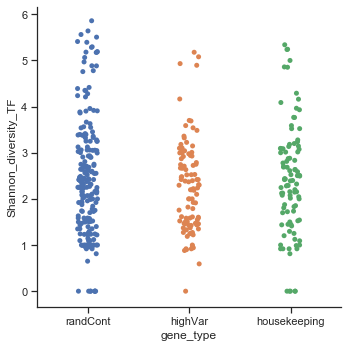

In [262]:
sns.catplot(x="gene_type", y="Shannon_diversity_TF", data=merged).savefig('../../data/plots/TF_diversity/responsive_TF_diversity.pdf', format='pdf')

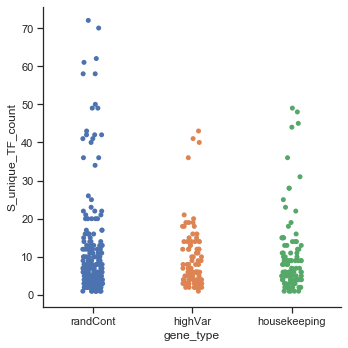

In [263]:
sns.catplot(x="gene_type", y="S_unique_TF_count", data=merged).savefig('../../data/plots/TF_diversity/responsive_no_of_unique_TFs.pdf', format='pdf')

### looks to be no different between promoter types!

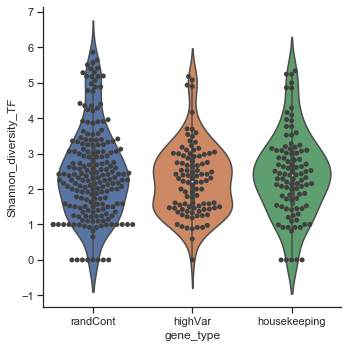

In [264]:
plot = sns.catplot(x="gene_type", y="Shannon_diversity_TF", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="Shannon_diversity_TF", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_shannondiversity_violin.pdf', format='pdf')

#### get names of each promoter type for later

In [265]:
pd.Categorical(merged.gene_type)
names = merged.gene_type.unique()
for name in names:
    print(name)

randCont
highVar
housekeeping


### test normaliity

In [266]:
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.Shannon_diversity_TF[merged.gene_type == name])))

randCont: (0.963759183883667, 4.713857561000623e-05)
highVar: (0.9589629769325256, 0.0036050041671842337)
housekeeping: (0.9770366549491882, 0.08375871926546097)


### reject normality

### make separate dfs based on gene_type

In [267]:
constitutive = merged[merged.gene_type == 'highVar']
#reset indexes so residuals can be calculated later
constitutive.reset_index(inplace=True)

responsive = merged[merged.gene_type == 'housekeeping']
responsive.reset_index(inplace=True)

control = merged[merged.gene_type == 'randCont']
control.reset_index(inplace=True)

### q-plot - constitutive

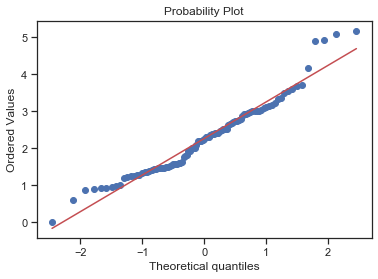

In [268]:
stats.probplot(constitutive.Shannon_diversity_TF, plot= plt);

### q-plots - responsive

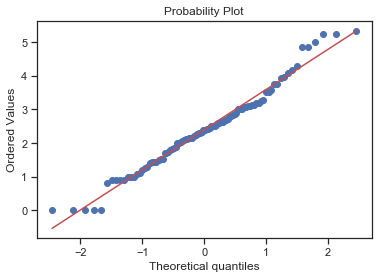

In [269]:
stats.probplot(responsive.Shannon_diversity_TF, plot= plt);

### q-plots - random control

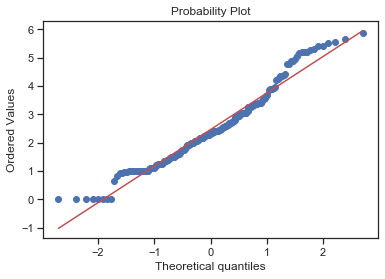

In [270]:
stats.probplot(control.Shannon_diversity_TF, plot= plt);

## test homoscedasticity (Homogeneity of Variance)

In [271]:
stats.levene(merged.Shannon_diversity_TF[merged.gene_type == names[0]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[2]])

LeveneResult(statistic=2.721365744170788, pvalue=0.06701533788772812)

#### fail to reject null hypothesis that variances are equal

# Kruskal-Wallis one way anlysis of variance: scipy.stats.kruskal

In [274]:
stats.kruskal(merged.Shannon_diversity_TF[merged.gene_type == names[0]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[2]])

KruskalResult(statistic=1.1958303966297146, pvalue=0.5499569930239621)

In [275]:
#variable vs housekeeping
stats.mannwhitneyu(merged.Shannon_diversity_TF[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4472.5, pvalue=0.17238318559642085)

### not significantly different

## TF_family shannon diversity

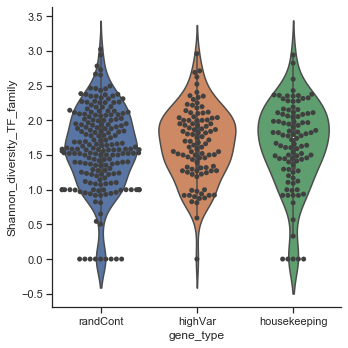

In [279]:
plot = sns.catplot(x="gene_type", y="Shannon_diversity_TF_family", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="Shannon_diversity_TF_family", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_shannondiversity_family_violin.pdf', format='pdf')

In [276]:
#test normality
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.Shannon_diversity_TF_family[merged.gene_type == name])))

randCont: (0.9666456580162048, 0.0001020822164718993)
highVar: (0.9888584613800049, 0.5807167291641235)
housekeeping: (0.9447304606437683, 0.00043969234684482217)


In [260]:
#not normal

,promoter_AGI,S_unique_TF_count,Shannon_diversity_TF,Shannon_diversity_TF_family,gene,gene_type,raw_TF_count
0,AT1G01050,4,1.842371,1.842371,AT1G01050,randCont,7
1,AT1G01780,19,3.147482,1.718292,AT1G01780,highVar,119
2,AT1G01910,16,3.763856,2.323856,AT1G01910,housekeeping,25
3,AT1G02000,7,2.750000,2.000000,AT1G02000,highVar,8
4,AT1G03070,43,4.931641,2.403916,AT1G03070,highVar,101
...,...,...,...,...,...,...,...
394,AT5G65360,5,2.155639,1.561278,AT5G65360,randCont,8
395,AT5G65470,3,1.251629,1.251629,AT5G65470,randCont,6
396,AT5G66250,1,-0.000000,-0.000000,AT5G66250,randCont,1
397,AT5G67210,9,2.928213,2.690469,AT5G67210,highVar,20


In [277]:
#test variance
stats.levene(merged.Shannon_diversity_TF_family[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF_family[merged.gene_type == names[2]])

LeveneResult(statistic=1.4043741966997705, pvalue=0.23743478432660753)

In [278]:
#mann whitney
#variable vs housekeeping
stats.mannwhitneyu(merged.Shannon_diversity_TF_family[merged.gene_type == names[1]], 
               merged.Shannon_diversity_TF_family[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4733.5, pvalue=0.38497616757211106)

## Analyse unique TFBS counts within promoters

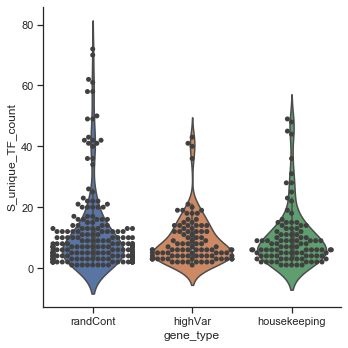

In [110]:
plot = sns.catplot(x="gene_type", y="S_unique_TF_count", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="S_unique_TF_count", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_unique_count.pdf', format='pdf')

In [111]:
#normality test
#returns test statistic, p-value
for name in names:
    print('{}: {}'.format(name, stats.shapiro(merged.S_unique_TF_count[merged.gene_type == name])))

randCont: (0.6819181442260742, 2.666510537865421e-19)
highVar: (0.7530405521392822, 1.3124110305462455e-11)
housekeeping: (0.7344346046447754, 5.062736688210556e-12)


test homoscedasticity (Homogeneity of Variance)

In [112]:
stats.levene(merged.S_unique_TF_count[merged.gene_type == names[0]], 
               merged.S_unique_TF_count[merged.gene_type == names[1]], 
               merged.S_unique_TF_count[merged.gene_type == names[2]])

LeveneResult(statistic=2.2622211227667703, pvalue=0.10546297048499476)

In [ ]:
#fail to reject null hypothesis that variances are equal

In [ ]:
#mann-whitney test

In [117]:
#variable vs housekeeping
stats.mannwhitneyu(merged.S_unique_TF_count[merged.gene_type == names[1]], 
               merged.S_unique_TF_count[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4679.5, pvalue=0.3341201165026155)

## Analyse raw TFBS counts within promoters

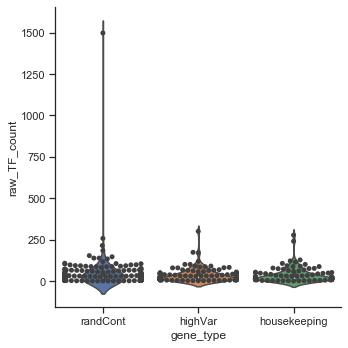

In [158]:
plot = sns.catplot(x="gene_type", y="raw_TF_count", data=merged, kind='violin')
#plot points
ax = sns.swarmplot(x="gene_type", y="raw_TF_count", data=merged, color=".25").get_figure().savefig('../../data/plots/TF_diversity/responsive_TF_raw_count.pdf', format='pdf')

In [159]:
#variable vs housekeeping
stats.mannwhitneyu(merged.raw_TF_count[merged.gene_type == names[1]], 
               merged.raw_TF_count[merged.gene_type == names[2]])

MannwhitneyuResult(statistic=4660.0, pvalue=0.3169447209456133)